# Process, Clean, and Save all Auxiliary Data Sets

In [13]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import pickle
from astropy.time import Time
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import rioxarray as rxr
from shapely.geometry import Point

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

## Clean the Outline file

In [78]:
outline_gdf = gpd.read_file('../../data/site_outlines/methow_outline.geojson')
outline_gdf = outline_gdf[3:4]

# save a version in 4236
outline_fn = '../../data/site_outlines/methow_outline_4326.pkl'
with open(outline_fn, 'wb') as f:
    pickle.dump(outline_gdf, f)

# conver to 32610
outline_gdf = outline_gdf.to_crs('EPSG:32610')

# save a version in 3260
outline_fn = '../../data/site_outlines/methow_outline_32610.pkl'
with open(outline_fn, 'wb') as f:
    pickle.dump(outline_gdf, f)

## Find the approximate center of the Methow lidar data and make a radius around it, for identifying nearby snotel

In [14]:
# Load in the saved outline file
dnr_gdf = pickle.load(open('../../data/site_outlines/methow_outline_32610.pkl',  'rb'))

In [15]:
# Find the center
dnr_snowoff_extent = dnr_gdf.total_bounds
x1, y1 = dnr_snowoff_extent[0], dnr_snowoff_extent[1]
x2, y2 = dnr_snowoff_extent[2], dnr_snowoff_extent[3]

x_center = (x1 + x2) / 2
y_center = (y1 + y2) / 2

center = Point((x_center,y_center))
print(center)

POINT (704824.5821600494 5378450.688569823)


In [16]:
df_center= pd.DataFrame({'Location':['center']})
gdf_center = gpd.GeoDataFrame(df_center, geometry=[center], crs=dnr_gdf.crs)
gdf_center['geometry'] = gdf_center.geometry.buffer(35000)
gdf_center

,Location,geometry
0,center,"POLYGON ((739824.582 5378450.689, 739656.048 5..."


<AxesSubplot: >

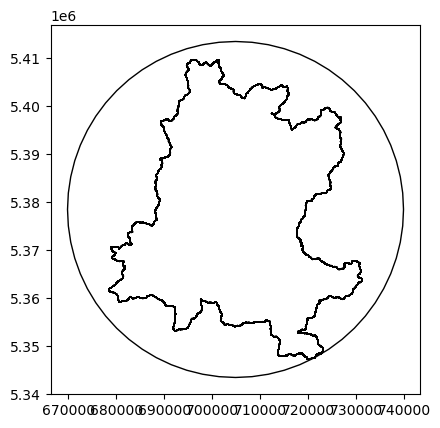

In [17]:
fig, ax = plt.subplots()

dnr_gdf.plot(facecolor='none', ax=ax)
gdf_center.plot(facecolor='none', ax=ax)


## Get SNOTEL for same date range and add to time series

In [ ]:
#Install directly from github repo main branch
#%pip install -q git+https://github.com/ulmo-dev/ulmo.git
#!conda install -y ulmo

In [11]:
#Despite warning, shouldn't need to restart kernel if all goes well with pip install
import ulmo

In [12]:
#This is the latest CUAHSI API endpoint
#http://his.cuahsi.org/wofws.html
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [18]:
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()
sites_df['geometry'] = [Point(float(loc['longitude']), float(loc['latitude'])) for loc in sites_df['location']]

sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({"elevation_m":float})

sites_gdf = gpd.GeoDataFrame(sites_df, crs='EPSG:4326', geometry=sites_df['geometry'])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [20]:
# Create a transform that will go from the native ICESat-2 and Snotel CS (4326) to the common projection we will use (32610, ie UTM Zone 10 N)

target_crs = "EPSG:32610"
from pyproj import Transformer,CRS
to_target_crs = Transformer.from_crs(4326,target_crs)

In [21]:
# Transform the snotel site locations to 32610

points_snotel = []
points = list(zip(sites_gdf.geometry.y, sites_gdf.geometry.x, sites_gdf.elevation_m))
for pt in to_target_crs.itransform(points):
    points_snotel.append(pt)
x_snotel = [x_tuple[0] for x_tuple in points_snotel]
y_snotel = [y_tuple[1] for y_tuple in points_snotel]
z_snotel = [z_tuple[2] for z_tuple in points_snotel]
sites_gdf_transformed = gpd.GeoDataFrame(sites_gdf, geometry=gpd.points_from_xy(x_snotel, y_snotel), crs='EPSG:32610')     # crs='EPSG:32610' - took this out because of deprecation warning
sites_gdf_transformed['elevation_transformed'] = z_snotel

In [22]:
sites_gdf_transformed.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
snotel_35km = gpd.clip(sites_gdf_transformed, gdf_center)

In [24]:
print(snotel_35km.crs)

EPSG:32610


<AxesSubplot: >

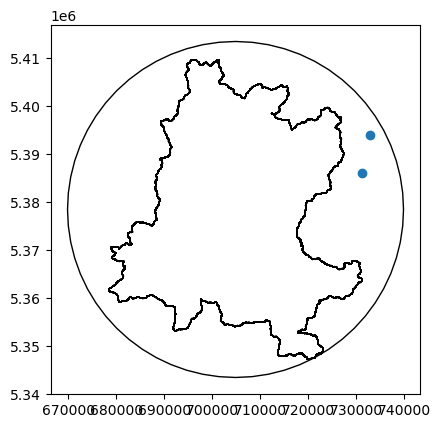

In [25]:
fig, ax = plt.subplots()

dnr_gdf.plot(facecolor='none', ax=ax)
gdf_center.plot(facecolor='none', ax=ax)
snotel_35km.plot(ax=ax)

In [26]:
snotel_35km.head(2)

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959


In [28]:
from datetime import date

dt_min = '2018-10-03' #First light ICESat-2
dt_max = date.today()   #'2022-02-01'

In [29]:
#Get current datetime
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

def snotel_fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date=dt_min, end_date=dt_max):
    #print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True) #pd.to_datetime(values_df['datetime'], utc=True) , freq='us'
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

In [30]:
#Daily SWE
#variablecode = 'SNOTEL:WTEQ_D'
#Daily snow depth
variablecode = 'SNOTEL:SNWD_D'

In [76]:
# SNOTEL sites with a 35km radius of the Methow
pkl_fn = '../data/snotel/snotel_snwd_35.pkl'
gdf = snotel_35km

if os.path.exists(pkl_fn):
    snwd_df = pd.read_pickle(pkl_fn)
else:
    #Define an empty dictionary to store returns for each site
    value_dict = {}
    for i, sitecode in enumerate(gdf.index):
        print('%i of %i sites' % (i+1, len(gdf.index)) )
        #out = fetch(sitecode, variablecode, start_date, end_date)
        out = snotel_fetch(sitecode, variablecode)
        if out is not None:
            value_dict[sitecode] = out['value']
    #Convert the dictionary to a DataFrame, automatically handles different datetime ranges (nice!)
    snwd_df = pd.DataFrame.from_dict(value_dict)
    #convert to meters
    snwd_df = snwd_df * 0.0254
    add_dowy(snwd_df)
    #Write out
    print(f"Writing out: {pkl_fn}")
    snwd_df.to_pickle(pkl_fn)

1 of 2 sites
2 of 2 sites
Adding Day of Water Year (DOWY)
Writing out: ../data/snotel/snotel_snwd_35.pkl


## Make a 5km Buffer Around Sites

In [50]:
snwd_df.head(2)

,SNOTEL:1259_WA_SNTL,SNOTEL:728_WA_SNTL
datetime,,
2018-10-03 00:00:00+00:00,0.0,0.0
2018-10-04 00:00:00+00:00,0.0,0.0


In [52]:
snotel_35km.head(2)

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959


In [62]:
snotel_35km.code

SNOTEL:1259_WA_SNTL    1259_WA_SNTL
SNOTEL:728_WA_SNTL      728_WA_SNTL
Name: code, dtype: object

In [63]:
from shapely.geometry import Point

muck = Point((snotel_35km[snotel_35km['code'] == '1259_WA_SNTL'].geometry.x, snotel_35km[snotel_35km['code'] == '1259_WA_SNTL'].geometry.y))
salmon = Point((snotel_35km[snotel_35km['code'] == '728_WA_SNTL'].geometry.x, snotel_35km[snotel_35km['code'] == '728_WA_SNTL'].geometry.y))

In [67]:
df_center= pd.DataFrame({'site':'muck_5km','geometry':[muck]})
df_center.loc[len(df_center)]={'site':'salmon_5km', 'geometry':salmon}
df_center

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/construction.py:810: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)


,site,geometry
0,muck_5km,POINT (731093.7835653129 5386094.281873972)
1,salmon_5km,POINT (732831.7348415289 5393950.294435121)


In [68]:
gdf_center = gpd.GeoDataFrame(df_center, geometry=df_center['geometry'], crs='epsg:32610')
gdf_center['geometry'] = gdf_center.geometry.buffer(5000)
gdf_center

,site,geometry
0,muck_5km,"POLYGON ((736093.784 5386094.282, 736069.707 5..."
1,salmon_5km,"POLYGON ((737831.735 5393950.294, 737807.658 5..."


In [77]:
snotel_35km

,code,name,network,elevation_m,site_property,geometry,elevation_transformed
SNOTEL:1259_WA_SNTL,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055
SNOTEL:728_WA_SNTL,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959


<AxesSubplot: >

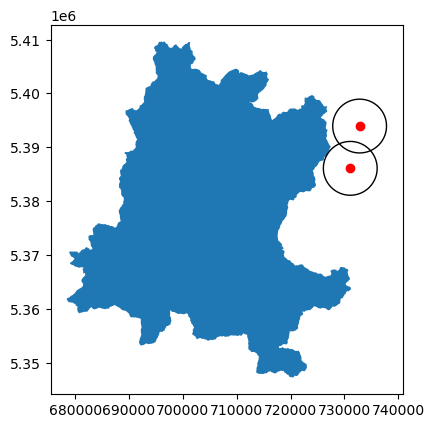

In [71]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
snotel_35km.plot(ax=ax, c='r')
gdf_center.plot(ax=ax, facecolor='none')

## Combine the geodataframes

In [72]:
snotel_geom = pd.concat([snotel_35km, gdf_center], ignore_index=True)
snotel_geom

,code,name,network,elevation_m,site_property,geometry,elevation_transformed,site
0,1259_WA_SNTL,Muckamuck,SNOTEL,1362.456055,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (731093.784 5386094.282),1362.456055,NaN
1,728_WA_SNTL,Salmon Meadows,SNOTEL,1359.407959,"{'county': 'Okanogan', 'state': 'Washington', ...",POINT (732831.735 5393950.294),1359.407959,NaN
2,NaN,NaN,NaN,NaN,NaN,"POLYGON ((736093.784 5386094.282, 736069.707 5...",NaN,muck_5km
3,NaN,NaN,NaN,NaN,NaN,"POLYGON ((737831.735 5393950.294, 737807.658 5...",NaN,salmon_5km


### Save the radius geodataframes

In [75]:
out_fn = '../data/snotel/snotel_geometries.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(snotel_geom, f)

# Load in Snow Depth Data from Community Snow Observations  
https://app.communitysnowobs.org/

In [79]:
cso = gpd.read_file('../../data/cso/cso-data.geojson')

In [80]:
cso.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

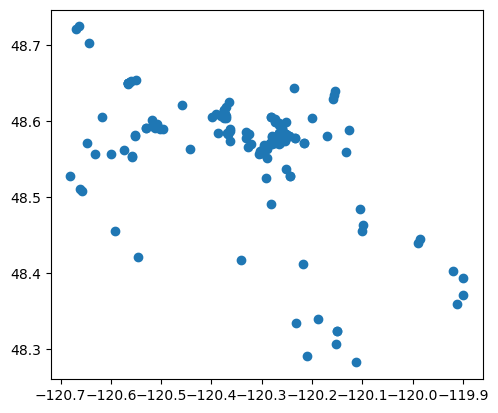

In [81]:
cso.plot()

In [82]:
cso = cso.to_crs('epsg:32610')

In [83]:
cso.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry
0,va0zhRE1,Bob Sutherland,34.999999,MountainHub,2020-01-22 21:26:35.335000+00:00,1241.020142,1579728395335,POINT (729538.759 5364683.919)
1,uasqsrAK,Bob Sutherland,74.999997,MountainHub,2021-02-17 19:56:22.817000+00:00,1027.264893,1613591782817,POINT (722635.255 5369454.743)
2,V9/l9iNg,Carmen Vanbianchi,35.560000,MountainHub,2020-02-19 19:38:38.466000+00:00,1281.596191,1582141118466,POINT (711513.278 5382422.710)
3,PUZnqkOp,Bob Sutherland,33.020000,MountainHub,2019-01-07 20:53:12.443000+00:00,839.739136,1546894392443,POINT (714425.271 5370892.693)
4,BR+RpKNc,Bob Sutherland,62.999998,MountainHub,2021-03-10 20:08:53.982000+00:00,847.298218,1615406933982,POINT (711886.207 5385614.469)


<AxesSubplot: >

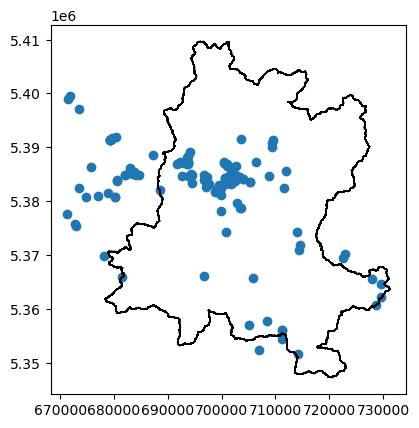

In [85]:
fig, ax = plt.subplots()

cso.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

In [86]:
# convert from cm to meters
cso['depth_m'] = cso['depth']/100

In [88]:
cso['time'] = pd.to_datetime(cso['timestamp'])
cso = cso.set_index('time')
cso.head()

,id,author,depth,source,timestamp,elevation,_ms,geometry,depth_m
time,,,,,,,,,
2020-01-22 21:26:35.335000+00:00,va0zhRE1,Bob Sutherland,34.999999,MountainHub,2020-01-22 21:26:35.335000+00:00,1241.020142,1579728395335,POINT (729538.759 5364683.919),0.3500
2021-02-17 19:56:22.817000+00:00,uasqsrAK,Bob Sutherland,74.999997,MountainHub,2021-02-17 19:56:22.817000+00:00,1027.264893,1613591782817,POINT (722635.255 5369454.743),0.7500
2020-02-19 19:38:38.466000+00:00,V9/l9iNg,Carmen Vanbianchi,35.560000,MountainHub,2020-02-19 19:38:38.466000+00:00,1281.596191,1582141118466,POINT (711513.278 5382422.710),0.3556
2019-01-07 20:53:12.443000+00:00,PUZnqkOp,Bob Sutherland,33.020000,MountainHub,2019-01-07 20:53:12.443000+00:00,839.739136,1546894392443,POINT (714425.271 5370892.693),0.3302
2021-03-10 20:08:53.982000+00:00,BR+RpKNc,Bob Sutherland,62.999998,MountainHub,2021-03-10 20:08:53.982000+00:00,847.298218,1615406933982,POINT (711886.207 5385614.469),0.6300


In [25]:
cso.elevation.describe()

count     139.000000
mean     1094.985954
std       277.990580
min       583.248718
25%       926.024841
50%      1036.673584
75%      1162.757812
max      1941.823120
Name: elevation, dtype: float64

In [89]:
cso_methow = gpd.clip(cso, outline_gdf)

<AxesSubplot: >

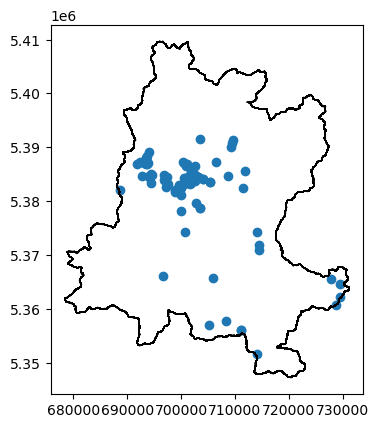

In [90]:
fig, ax = plt.subplots()

cso_methow.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

### Save the CSO Geodataframe

In [91]:
out_fn = '../../data/cso/cso-data.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(cso_methow, f)